# Deep Learning Models



Importing the data and libraries

In [2]:
# Loading data and libraries
import numpy as np
import pandas as pd
import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
df = pd.read_csv("ted_main.csv")
df.columns

In [ ]:

df = df[['name', 'title', 'description', 'main_speaker', 'speaker_occupation', 'num_speaker', 'duration', 'event', 'film_date', 'published_date', 'comments', 'tags', 'languages', 'ratings', 'related_talks', 'url', 'views']]


In [ ]:

import datetime
df['film_date'] = df['film_date'].apply(lambda x: datetime.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))
df['published_date'] = df['published_date'].apply(lambda x: datetime.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))

In [ ]:

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [ ]:
df[['event']]

In [ ]:

df['month'] = df['film_date'].apply(lambda x: month_order[int(x.split('-')[1]) - 1])

month_df = pd.DataFrame(df['month'].value_counts()).reset_index()
month_df.columns = ['month', 'talks']


# Read in the 'ted' talk data.

In [ ]:

ted = pd.read_csv('ted_main.csv')

In [ ]:
# Categorize events into TED and TEDx; exclude those that are non-TED events
ted = ted[ted['event'].str[0:3]=='TED'].reset_index()

In [ ]:
ted.loc[:,'event_cat'] = ted['event'].apply(lambda x: 'TEDx' if x[0:4]=='TEDx' else 'TED')
print ("No. of talks remain: ", len(ted))

Here, we change the Unix timstamp to human readable date format. Then we extract month and day of week from film date and published date.

In [ ]:

ted['film_date'] = ted['film_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
ted['published_date'] = ted['published_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
ted['film_month'] = ted['film_date'].apply(lambda x: x.month)
ted['pub_month'] = ted['published_date'].apply(lambda x: x.month)
ted['film_weekday'] = ted['film_date'].apply(lambda x: x.weekday()) # Monday: 0, Sunday: 6
ted['pub_weekday'] = ted['published_date'].apply(lambda x: x.weekday())
ted[['film_date','published_date']].head()

TED users can give ratings to each talk. There are 14 possible ratings and they will be categorized as positive, negative and neutral:

Positive: 'Beautiful', 'Courageous', 'Fascinating', 'Funny', 'Informative', 'Ingenious', 'Inspiring', 'Jaw-dropping', 'Persuasive' Negative: 'Confusing', 'Longwinded', 'Obnoxious', 'Unconvincing' Neutral: 'OK'

Here, we define a "popular" TED talk by its ratio of positive to negative ratings (which we call it "popularity ratio" here). If the popularity ratio is above 5, it is defined as "Popular", otherwise it is "Not Popular". Transformation is made to avoid "divided by zero" error. The following code is adopted from this kernel to convert 'ratings' column (a JSON object) into columns of each rating

In [ ]:

ted['ratings']=ted['ratings'].str.replace("'",'"')
ted=ted.merge(ted.ratings.apply(lambda x: pd.Series(pd.read_json(x)['count'].values,index=pd.read_json(x)['name'])), 
            left_index=True, right_index=True)

In [ ]:
Positive = ['Beautiful', 'Courageous', 'Fascinating', 'Funny', 'Informative', 'Ingenious', 'Inspiring', 'Jaw-dropping', 'Persuasive']
Negative = ['Confusing', 'Longwinded', 'Obnoxious', 'Unconvincing']
ted['positive']=ted.loc[:,Positive].sum(axis=1)+1
ted['negative']=ted.loc[:,Negative].sum(axis=1)+1
ted['pop_ratio']=ted['positive']/ted['negative']
ted.loc[:,'Popular'] = ted['pop_ratio'].apply (lambda x: 1 if x >5 else 0)

print ("No. of Not Popular talks: ", len(ted[ted['Popular']==0]))
# print ("Ratio of Popular talks: {:.4f}".format(len(ted[ted['Popular']==1])/ float(len(ted))))
overall_mean_popular = np.mean(ted.Popular)
print ("Ratio of Popular talks: {:.4f}".format(overall_mean_popular))

In [ ]:
nums = ['comments', 'duration', 'languages', 'num_speaker', 'views']
sns.pairplot(ted, vars=nums, hue='Popular', hue_order = [1,0], diag_kind='kde', height=3);

In [ ]:
ratings = ['Funny', 'Beautiful', 'Ingenious', 'Courageous', 'Longwinded', 'Confusing', 'Informative', 'Fascinating', 'Unconvincing', 
           'Persuasive', 'Jaw-dropping', 'OK', 'Obnoxious', 'Inspiring', 'Popular']
plt.figure(figsize=(10,8))
sns.heatmap(ted[ratings].corr(), annot=True, cmap='RdBu');

In [ ]:
Then we do count vectorizer on 'speaker_occupation'. Before that, some data cleaning is needed.

In [ ]:

ted.loc[:,'occ'] = ted.speaker_occupation.copy()
ted.occ = ted.occ.fillna('Unknown')
ted.occ = ted.occ.str.replace('singer/songwriter', 'singer, songwriter')
ted.occ = ted.occ.str.replace('singer-songwriter', 'singer, songwriter')
count_vector2 = CountVectorizer(stop_words='english', min_df=20/len(ted))
occ_array = count_vector2.fit_transform(ted.occ).toarray()
occ_matrix = pd.DataFrame(occ_array, columns = count_vector2.get_feature_names())
all_occ = occ_matrix.columns
occ_matrix = pd.concat([occ_matrix, ted.Popular], axis=1)
by_occ = dict()
for col in all_occ:
    by_occ[col]=occ_matrix.groupby(col)['Popular'].mean()[1] - overall_mean_popular
occ_rank = pd.DataFrame.from_dict(by_occ, orient='index')
occ_rank.columns = ['pop_rate_diff']

plt.figure(figsize=(16,7))
plt.subplot(121)
bar_2 = occ_rank.sort_values(by='pop_rate_diff', ascending=False)[:10]
sns.barplot(x=bar_2.pop_rate_diff, y=bar_2.index, color='blue')
plt.title('10 Most Popular Occupation Keywords', fontsize=14)
plt.xlabel('Ratio of Popular Talk (Net of Mean)')
plt.yticks(fontsize=12)
plt.subplot(122)
bar_1 = occ_rank.sort_values(by='pop_rate_diff')[:10]
sns.barplot(x=bar_1.pop_rate_diff, y=bar_1.index, color='red')
plt.title('10 Most Unpopular Occupation Keywords', fontsize=14)
plt.xlabel('Ratio of Popular Talk (Net of Mean)')
plt.yticks(fontsize=12)
plt.show()

In [ ]:
print("Number of non-Ted talks that we removed were:", len(df) - len(ted))

# Structure of the data

In [ ]:
from scipy.stats import pearsonr


In [ ]:
corr, _ = pearsonr(df['comments'], df['views']); corr # As can be seen, not much of a correlation between the two.

In [ ]:
# if we include all the talks will the correlation between comments and views increase or decrease?

corr, _ = pearsonr(ted['comments'], ted['views']); corr # it decreases!

Word Cloud for popular and nonpopular talks.


Popular classification prediction model.

We will build a prediction model to prediction which talks are popular, starting with tags, speaker occupations, title and description. As we are having a problem of highly unbalanced class, we only predict a talk to be 'Popular' if the probability of having a 'Popular' label is above 65%.

# Building a simple shallow neural network to predict views

# Univariable Shallow network

Use comments as input and views as output.

In [ ]:
df_comments = df['comments']; df_views = df['views']

In [ ]:
df_comments

In [ ]:
df_views

Split the data in train and test sets

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_comments, df_views, test_size=0.2, random_state=1)

for set in [X_train, X_test, y_train, y_test]:
    print( len(set))

In [ ]:
#pip install --upgrade keras
#pip install --upgrade tensorflow

#Import required packages

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteError, MeanSquaredLogarithmicError, CosineSimilarity
from keras import metrics

import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')

print(hello)

In [ ]:
# Model 1 (Do not run this cell already have the results saved.)

# Specify the modelmodel = Sequential()
model_1_neuron = Sequential()
model_1_neuron.add(Dense(1, input_dim = 1, activation = "relu"))
model_1_neuron.compile(loss='mse', optimizer='adam', 
          #metrics = ["mse", "RMSE", "mape"])
            metrics = [ MeanSquaredError(), RootMeanSquaredError(),MeanAbsoluteError(), MeanAbsolutePercentageError(), MeanSquaredLogarithmicError()])


# Fit the model, or in other words, train the model. 

#Train the model and make predictions
history = model_1_neuron.fit(X_train, y_train, epochs=100 , batch_size=32, verbose = 2, validation_split=0.2)
score = model_1_neuron.evaluate(X_test, y_test, verbose = 2)

#Make predictions from the trained model
predictions = model_1_neuron.predict(X_test)

#print performance and loss
print("Performance on Test set:", zip(model_1_neuron.metrics_names, score))

In [ ]:
# Manually get rmse
(np.mean((np.array(y_test) - predictions)**2))**.5 # we got 2545996.0559998746 04 April 2021

In [ ]:

# "Plot Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# "Plot Loss"
#plt.plot(history.history['MeanSquaredError'])
#plt.plot(history.history['val_loss'])
#plt.title('model Metrics')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper right')
#plt.show()

# plot metrics
plt.plot(history.history['mean_squared_error'])
#plt.plot(history.history['mean_absolute_error'])
#plt.plot(history.history['mean_absolute_percentage_error'])
#pyplot.plot(history.history['cosine_proximity'])
plt.show()

In [ ]:
# plot metrics
plt.plot(history.history['mean_absolute_error'])
plt.show()

In [ ]:

# plot metrics
plt.plot(history.history['mean_squared_logarithmic_error'])
plt.show()

In [ ]:
# plot metrics
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['mean_squared_logarithmic_error'])
plt.show()

# Code from book



In [ ]:
# Model 2

def train_given_optimiser(optimiser):
    
 model = Sequential()
 model.add(Dense(2, input_dim=1))
 model.add(Activation(activation='relu'))


 model.compile(optimizer=optimiser, loss='msle', metrics=['mse', 'mape', RootMeanSquaredError(), 'msle' ])
    
 score = model.evaluate(X_train,y_train, verbose=2)

 print ("Optimiser: ", optimiser)
 print ("Before Training:", list(zip(model.metrics_names, score)))
 model.fit(X_train,y_train, epochs=10, batch_size=32, verbose=0)
 score = model.evaluate(X_test, y_test, verbose=0)
 print ("After Training:", list(zip(model.metrics_names, score)))
 print (score)
 print (model.metrics_names)
 print (" \n ")
    
# Running function for different optimizers 
train_given_optimiser("sgd")
train_given_optimiser("rmsprop")
train_given_optimiser("adagrad")
train_given_optimiser("adadelta")
train_given_optimiser("adam")
train_given_optimiser("adamax")
train_given_optimiser("nadam")


Write a function that outputs the variables to store in the resutls data frame above.

In [ ]:
def model_results(model_num, 
                  optimizer = 'adam', 
                  loss_fn = 'mse', 
                  activation_fn = 'relu', 
                  output_activation_fn = 'relu', 
                  
                  epochs = 100, 
                  batch_size =32, 
                  
                  neurons_in_inputlayer = 5, 
                  num_hiddenlayer = 1,  
                  neurons_in_hiddenlayer = 2, 
                  num_dropout_layers = 0,
                  
                  verbose = 0):  
    
    # The Model
    
    model = Sequential()
    # Input Layer
    model.add(Dense(neurons_in_inputlayer, input_dim = 1, activation = activation_fn))
    # Dropout Layer
    #model.add(Dropout(rate = 0.1,seed=100))
    # Hidden Layers
    model.add(Dense(neurons_in_hiddenlayer,activation = activation_fn))
    # Output Layer
    model.add(Dense(1,activation = output_activation_fn))

    
    # Compiling the model
    model.compile(loss=loss_fn, optimizer=optimizer,
    metrics=['mse', 'mae', 'mape', CosineSimilarity(), RootMeanSquaredError() , MeanSquaredLogarithmicError() ])
    # Train the model and make predictions
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose = verbose)
    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose = verbose)
    
    # Make predictions from the trained model
    #predictions = model.predict(X_test)
    
    # Store results
    dict = {'model_num':[model_num],
        'optimizer':[ optimizer],
        'loss_fn':[loss_fn],
        'activation_fn':[activation_fn],
        'output_activation_fn':[output_activation_fn],
        'epochs':[epochs],
        'batch_size':[batch_size],
        'neurons_in_inputlayer':[neurons_in_inputlayer],
        'num_hiddenlayer':[num_hiddenlayer],
        'neurons_in_hiddenlayer':[neurons_in_hiddenlayer],
        'num_dropout_layers':[num_dropout_layers],            
        'loss':[score[0]],
        'mse_test':[score[1]],
        'mae_test':[score[2]],
        'mape_test':[score[3]],
        'cosine_similarity_test':[score[4]],
        'rmse_test':[score[5]],
        'msle_test':[score[6]] 
       }

    results_df = pd.DataFrame(dict)
    #print ("After Training:", list(zip(model.metrics_names, score)))
    return(results_df)

model_results(0)

In [ ]:
dict = {'model_num':[],
        'optimizer':[ ],
        'loss_fn':[],
        'activation_fn':[],
        'output_activation_fn':[],
        'epochs':[],
        'batch_size':[],
        'neurons_in_inputlayer':[],
        'num_hiddenlayer':[],
        'neurons_in_hiddenlayer':[],
        'num_dropout_layers':[],            
        'loss':[],
        'mse_test':[],
        'mae_test':[],
        'mape_test':[],
        'cosine_similarity_test':[],
        'rmse_test':[],
        'msle_test':[] 
}

results_df = pd.DataFrame(dict)
results_df


In [ ]:

optimizer_list = ["nadam", "adam"]
loss_fn_list = ["mse", "mae", "msle"]
activation_fn_list = ["relu", "selu"]
epochs_list = [50, 100]
batch_size_list = [1, 10, 32, 100]
num_hiddenlayer_list = [1]
neurons_in_hiddenlayer_list = [1, 5, 10]
neurons_in_inputlayer_list = [1, 5, 10]
num_dropout_layers_list = [0]

number_parameters = len(optimizer_list) * len(loss_fn_list) * len(activation_fn_list) * len(epochs_list) * len(batch_size_list) * len(neurons_in_inputlayer_list) * len(neurons_in_hiddenlayer_list) * len(num_dropout_layers_list) 
print("number_parameters :", number_parameters)

print(2*3*2*2*4*3*3)

## Hyperparameter Grid Search Loop

In [ ]:
from datetime import datetime

start=datetime.now()


number_parameters = len(optimizer_list) * len(loss_fn_list) * len(activation_fn_list) * len(epochs_list) * len(batch_size_list) * len(neurons_in_inputlayer_list) * len(neurons_in_hiddenlayer_list) * len(num_dropout_layers_list) 
print("number_parameters :", number_parameters)
print(number_parameters)

i = 0
for opt in optimizer_list:
    for loss in loss_fn_list:
        for activation in activation_fn_list:
            for epochs in epochs_list:
                for batch in batch_size_list:
                    for neurons_in_inputlayer in neurons_in_inputlayer_list:
                        for neurons_in_hiddenlayer in neurons_in_hiddenlayer_list:
                            
                            results = model_results(model_num              = i, 
                                                    optimizer              = opt ,
                                                    loss_fn                = loss, 
                                                    activation_fn          = activation, 
                                                    output_activation_fn   = 'relu', 
                                                    epochs                 = epochs, 
                                                    batch_size             = batch, 
                                                    neurons_in_inputlayer  = neurons_in_inputlayer,
                                                    num_hiddenlayer        = 1,
                                                    neurons_in_hiddenlayer = neurons_in_hiddenlayer,
                                                    num_dropout_layers     = 0, 
                                                    verbose                = 0
                                                    )
                            
                            results_df = results_df.append(results, ignore_index = True)
                            print('i:', i)
                            print("Percent Complete", 100*i/number_parameters, '%')
                            print( ' \n ')
                            print(results)
                            print( ' \n ')
                            i+=1
                                
stop = datetime.now()

print('Time: ', stop - start)

In [ ]:

# Add information about the data structure to the model results. 
results_df['corr'] = corr

runtime = stop - start
print('Time: ', runtime)

results_df['total_runtime'] = runtime

print(results_df)

results_df.to_csv('Experiment4_results_views_vs_comments.csv')

results_df.describe()
print(len(results_df.columns))
print(results_df.columns)
print(results_df.shape)

### Read in the data from the saved results in the csv file. 

In [3]:
results_df = pd.read_csv("../Experimental_results/Experiment4_results_views_vs_comments.csv")
print(results_df.shape)
print(results_df.columns)

(866, 21)
Index(['Unnamed: 0', 'model_num', 'optimizer', 'loss_fn', 'activation_fn',
       'output_activation_fn', 'epochs', 'batch_size', 'neurons_in_inputlayer',
       'num_hiddenlayer', 'neurons_in_hiddenlayer', 'num_dropout_layers',
       'loss', 'mse_test', 'mae_test', 'mape_test', 'cosine_similarity_test',
       'rmse_test', 'msle_test', 'corr', 'total_runtime'],
      dtype='object')


In [4]:
# For each metric find min and max value combinations.
# First select the metric columns

results_df_metrics = results_df.loc[:, results_df.columns.str.contains('test')]
print(results_df_metrics.shape)
print(results_df_metrics.columns)
type(results_df_metrics.columns)

(866, 6)
Index(['mse_test', 'mae_test', 'mape_test', 'cosine_similarity_test',
       'rmse_test', 'msle_test'],
      dtype='object')


pandas.core.indexes.base.Index

In [5]:
# Find max values of the metrics values

print(results_df_metrics.max())

maxValueIndex = results_df_metrics.idxmax()
print(maxValueIndex)

mse_test                  6.967889e+12
mae_test                  1.634295e+06
mape_test                 1.000000e+02
cosine_similarity_test    1.000000e+00
rmse_test                 2.639676e+06
msle_test                 1.959891e+02
dtype: float64
mse_test                  723
mae_test                    0
mape_test                   0
cosine_similarity_test      3
rmse_test                 723
msle_test                   0
dtype: int64


In [6]:
# Finding min values of the metrics

print(results_df_metrics.min())

print()
minValueIndex = results_df_metrics.idxmin()
print(minValueIndex)
print()
print(minValueIndex.values)
results_df.iloc[minValueIndex.values]

mse_test                  4.141292e+12
mae_test                  9.809189e+05
mape_test                 5.182317e+01
cosine_similarity_test    0.000000e+00
rmse_test                 2.035017e+06
msle_test                 5.860268e-01
dtype: float64

mse_test                    4
mae_test                  262
mape_test                 256
cosine_similarity_test      0
rmse_test                   4
msle_test                 838
dtype: int64

[  4 262 256   0   4 838]


,Unnamed: 0,model_num,optimizer,loss_fn,activation_fn,output_activation_fn,epochs,batch_size,neurons_in_inputlayer,num_hiddenlayer,...,num_dropout_layers,loss,mse_test,mae_test,mape_test,cosine_similarity_test,rmse_test,msle_test,corr,total_runtime
4,4,2.0,nadam,mse,relu,relu,50.0,1.0,1.0,1.0,...,0.0,4.141292e+12,4.141292e+12,1048607.750,60.543694,1.0,2035016.625,1.189505,0.528903,0 days 09:08:40.950942
262,262,260.0,nadam,mae,selu,relu,100.0,1.0,10.0,1.0,...,0.0,9.809189e+05,4.255918e+12,980918.875,60.757793,1.0,2062987.625,0.667647,0.528903,0 days 09:08:40.950942
256,256,254.0,nadam,mae,selu,relu,100.0,1.0,1.0,1.0,...,0.0,1.058086e+06,4.790659e+12,1058086.500,51.823166,1.0,2188757.250,0.916736,0.528903,0 days 09:08:40.950942
0,0,0.0,nadam,mse,relu,relu,1.0,1.0,1.0,1.0,...,0.0,6.484386e+12,6.484386e+12,1634295.375,100.000000,0.0,2546445.750,195.989105,0.528903,0 days 09:08:40.950942
4,4,2.0,nadam,mse,relu,relu,50.0,1.0,1.0,1.0,...,0.0,4.141292e+12,4.141292e+12,1048607.750,60.543694,1.0,2035016.625,1.189505,0.528903,0 days 09:08:40.950942
838,838,836.0,adam,msle,selu,relu,100.0,1.0,10.0,1.0,...,0.0,5.860268e-01,5.225329e+12,1046295.750,72.798332,1.0,2285897.750,0.586027,0.528903,0 days 09:08:40.950942


In [12]:
idx_min_rmse = results_df.rmse_test.idxmin()
print(results_df.rmse_test.mean())
print(results_df.rmse_test.min())
print(idx_min_rmse)
results_df.iloc[idx_min_rmse]

2461181.9732967666
2035016.625
4


Unnamed: 0                                     4
model_num                                      2
optimizer                                  nadam
loss_fn                                      mse
activation_fn                               relu
output_activation_fn                        relu
epochs                                        50
batch_size                                     1
neurons_in_inputlayer                          1
num_hiddenlayer                                1
neurons_in_hiddenlayer                        10
num_dropout_layers                             0
loss                                 4.14129e+12
mse_test                             4.14129e+12
mae_test                             1.04861e+06
mape_test                                60.5437
cosine_similarity_test                         1
rmse_test                            2.03502e+06
msle_test                                1.18951
corr                                    0.528903
total_runtime       

In [7]:

# Convert the data from wide format to long format. use pd.melt()

results_df_long0 = pd.melt(results_df, id_vars='model_num', value_vars=results_df_metrics.columns)
results_df_long0

,model_num,variable,value
0,0.0,mse_test,6.484386e+12
1,0.0,mse_test,6.484386e+12
2,0.0,mse_test,6.484386e+12
3,1.0,mse_test,4.659994e+12
4,2.0,mse_test,4.141292e+12
...,...,...,...
5191,859.0,msle_test,3.139518e+01
5192,860.0,msle_test,3.476908e+01
5193,861.0,msle_test,1.959891e+02
5194,862.0,msle_test,4.270843e+01


# Visualize the hyperparameter search results


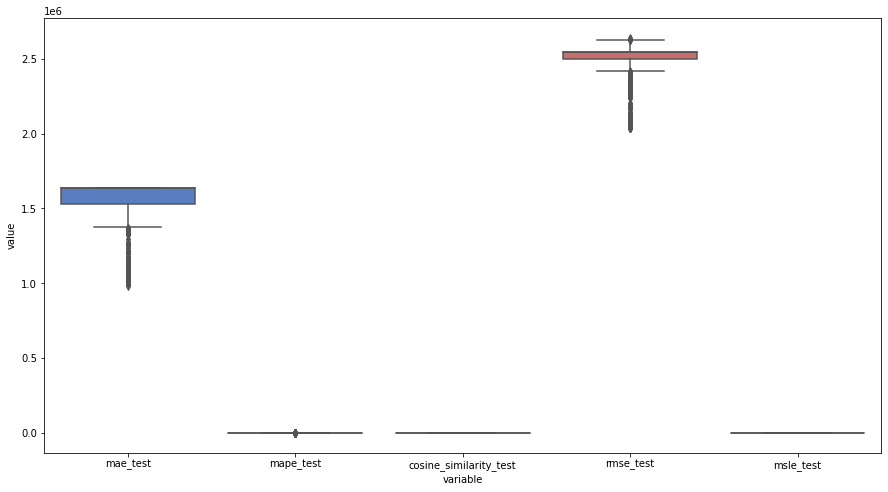

In [8]:
# Summarize the results as boxplots

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='variable', y='value', 
            data= results_df_long0[results_df_long0.variable!= 'mse_test'], 
            palette="muted", ax = ax)
plt.show()

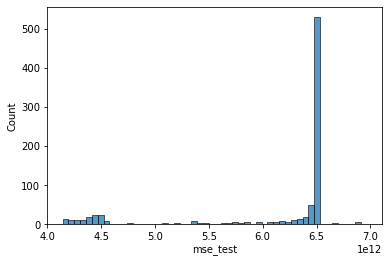

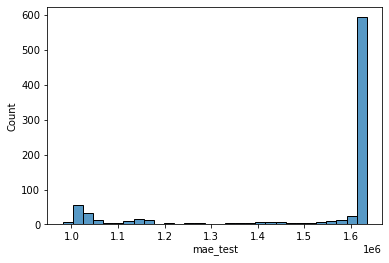

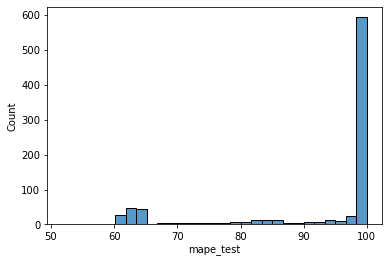

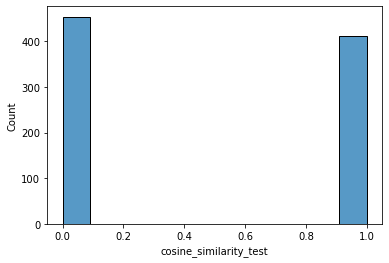

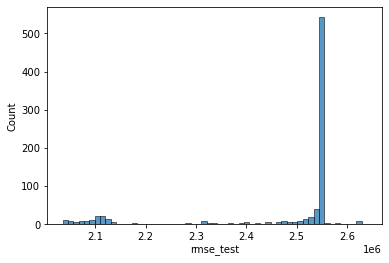

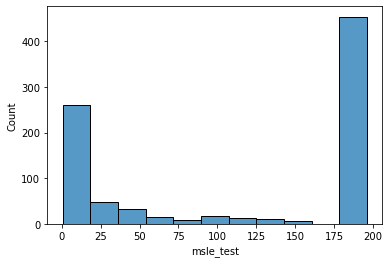

In [9]:
# Histogram using sns distribution

#sns.histplot(results_df.rmse_test)
#sns.displot(results_df.rmse_test)

#fig, ax = plt.subplots(nrows=3, ncols=2)
for metric in results_df_metrics.columns:

    #print(metric)
    sns.histplot(results_df[metric])
    plt.show()


This code is amazingly beautiful and I give full credit from where I copied it: Stackoverflow: https://stackoverflow.com/questions/34439/finding-what-methods-a-python-object-has¶
import pandas as pd df = pd.DataFrame([[10, 20, 30], [100, 200, 300]], columns=['foo', 'bar', 'baz']) def get_methods(object, spacing=20): methodList = [] for method_name in dir(object): try: if callable(getattr(object, method_name)): methodList.append(str(method_name)) except: methodList.append(str(method_name)) processFunc = (lambda s: ' '.join(s.split())) or (lambda s: s) for method in methodList: try: print(str(method.ljust(spacing)) + ' ' + processFunc(str(getattr(object, method).doc)[0:90])) except: print(method.ljust(spacing) + ' ' + ' getattr() failed')

get_methods(df['foo'])

In [ ]:
# Summarize the results

#plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot( data=results_df['mse_test', 'mae_test', 'rmse_test', 'msle_test']
plt.show()

Group by summary results: Grouping variables: loss_fn, optimizer, and activation_fn

We will search which combination of hyperparameters performs the best for the different metrics - and which metrics are useful.

# Multivariable Shallow Neural Network.

The data we will be using will be the 'ted' data since there is more preprossessing done on it. The ted data is missing non-ted talks as they are excluded.

Cleaning the data: Should the cleaning be done before or after the data splitting. To be 100% sure, it should be done after the splitting. However, the training data is cleaned so should the test data be. This is harder and more work, and because it is harder this is what we will do. To make it easy what is hard, make a function that only needs a data set to be passed in. The biggest issue of first cleaning is that it is possible to have information leak into the rows that will be used as test set from the training set. This 'leaky' problem must be avoided.

Obviously, I do know that some steps can be done before splitting the data and no information will be leaked e.g. deleting columns that are not variables. However, I propose just to make a function that does all the cleaning steps and simply applying the functions to both training and test sets. This way everything stays in one place and things are more tracable. Although, yes, it may be over work and better to quickly just get rid of all the columns first before anything is done.


Once the data is split into train and test. We could further divide the training data into train and validation sets. So our split of the data will be 60:20:20. What we can then do is while training the model using the 60% of the data also indicate in val_per = .2 so that cross validatio is also performed during the training phase. This three phases allow us to first train all the models, then on the validation set compare all the models and choosing the best performing one, and finally using the test set to find the accuracy of the best model in production. Now one last word. If the data set is very very large people at Dessa implementing deep learning for corporate clients have told me that cross validation can be left out, because the data is so large. My reasoning, if this is indeed the case, is because there is only redundant information learned by performing cross validation. The data is so large the model learns all the information in the data with regular training. Cross validation therefore, I surmise, can also be thought as a data augmentation method, nor a data trend augmentation, but data trend augmentation. Data trend augmentation is creating and replicating patterns in the data that already exist and making them stronger or more detectable.

Data Cleaning

Questions on data cleaning: Should we normalize the data for neural network models. We do not need to normalize the data for the random forest algorithm. I think we do not need to.

I will now perform the data cleaning steps which I first list down here for consision and comprehensive vision:

1. Remove columns that are not variables such as the indexing and other book keeping columns.
2. Create dummy variables for categorical data.
3. Make sure all the data is either numerical or categorical. Dates should be converted to numerical or categorical; should not be left as date type data.
4. Any other data cleaning steps that need to be done? Nothing at the moment comes to mind.

In [ ]:
# Again look at the data columns and the type of variables they are. 


print(ted.columns)
print(len(ted.columns))

# Remove the columns: index, url,

This has the day, and month, but not the year the talks were published. It should be created. Here the statistician in me asks is there sufficient benefit so as to create and add the variable, what the statistician is asking is does the cost of increasing the number of variables, which increases the number of degrees of freedom, making the model more flexible worth the variability explained by the model, or the increase in predictive power. The same question phrased by a computer scientist would be by adding this variable are we overfitting?

The statistician hence needs reminding that we only care about if the predictive power of the model increases. This is assessed in the tuning phase of the model when the accuracy is measured on the validation set. If including the variable increases the validation set accuracy then the student of computer scientist within me simply states we need not think any further; we are only interested in predictive power and not in explainability in itself.

In [ ]:
# We will create at the end a cleaned data set called ted_clean.

ted1 = ted.drop(['index', 'url', 'main_speaker', 'speaker_occupation', 'occ', 'film_date', 
                 'event', 'description', 'ratings', 'name', 'title', 'published_date' , 'related_talks', 'tags'], axis =1)
print(ted1.columns)
print(len(ted1.columns))
ted2 = pd.get_dummies(ted1)

print(ted2.columns)
print(len(ted2.columns))

Firstly, of all is it correct that so many are created? Secondly, are the correct ones made into dummy variables (i.e. only categorical data ones)? Lastly, is there a better way or since we are using a deep neural network this is good. Or even what we want?

First the proper non-trivial, but still basic model with proper variables and a deep neural network. Statistically speaking we will now do multivariable analysis, instead of univariable analysis, though still using shallow networks.
This only has one categorical variable: event_cat

We start with data splitting

In [ ]:
## Setting up the training and test data

# Seperate the data first into training and testing.
X_train, X_test, y_train, y_test = train_test_split( ted2.drop('views', axis = 1), ted['views'], test_size=0.2, random_state=1 )
                                                                                     
                                                                                     
for set in [X_train, X_test, y_train, y_test]:
    print( len(set) )
    
print(X_train.shape)

In [ ]:
print(X_train.shape)
X_train.shape[1]

In [ ]:
# Write the multivariable shallow network as a function that outputs the results and plots.

In [ ]:
# This is getting very long. Need to covert this into a script. 
def model_results(model_num, 
                  
                  #X_train = X_train,
                  #y_train = y_train,
                  #X_test = X_test, 
                  #y_test = y_test,
                  
                  optimizer = 'adam', 
                  loss_fn = 'mse', 
                  activation_fn = 'relu', 
                  output_activation_fn = 'relu', 
                  
                  epochs = 100, 
                  batch_size =32,
                  validation_split = 0.2,
                  
                  
                  neurons_in_inputlayer = 50, 
                  num_hiddenlayer = 1,  
                  neurons_in_hiddenlayer = 40, 
                  num_dropout_layers = 0,
                  
                  verbose = 0):  
    
    # The Model
    
    input_dimensions = X_train.shape[1]
    
    model = Sequential()
    # Input Layer
    model.add(Dense(neurons_in_inputlayer, input_dim = input_dimensions, activation = activation_fn))
    # Dropout Layer
    #model.add(Dropout(rate = 0.1,seed=100))
    # Hidden Layers
    model.add(Dense(neurons_in_hiddenlayer,activation = activation_fn))
    # Output Layer
    model.add(Dense(1,activation = output_activation_fn))

    
    # Compiling the model
    model.compile(loss=loss_fn, optimizer=optimizer,
    #metrics=['mse', 'mae', 'mape', CosineSimilarity(), RootMeanSquaredError() , MeanSquaredLogarithmicError() ])
    metrics=[ MeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError() 
             , CosineSimilarity() , RootMeanSquaredError(), MeanSquaredLogarithmicError()  ]   )

    # Train the model and make predictions
    model_fit=model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=verbose,validation_split=validation_split)
    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose = verbose)
    
    # Make predictions from the trained model
    #predictions = model.predict(X_test)
    
    # Store results
    dict = {'model_num':[model_num],
        'optimizer':[ optimizer],
        'loss_fn':[loss_fn],
        'activation_fn':[activation_fn],
        'output_activation_fn':[output_activation_fn],
        'epochs':[epochs],
        'batch_size':[batch_size],
        'validation_split':[validation_split],
        'input_dimensions':[input_dimensions],
        'neurons_in_inputlayer':[neurons_in_inputlayer],
        'num_hiddenlayer':[num_hiddenlayer],
        'neurons_in_hiddenlayer':[neurons_in_hiddenlayer],
        'num_dropout_layers':[num_dropout_layers],            
        'loss':[score[0]],
        'mse_test':[score[1]],
        'mae_test':[score[2]],
        'mape_test':[score[3]],
        'cosine_similarity_test':[score[4]],
        'rmse_test':[score[5]],
        'msle_test':[score[6]] 
       }
    
    
    # "Plot Loss"
    plt.plot(model_fit.history['loss'])
    plt.plot(model_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    
    # Plot metrics
    for metric in ['mean_squared_error', 'root_mean_squared_error' ,'mean_absolute_error', 'mean_absolute_percentage_error','cosine_similarity', 'mean_squared_logarithmic_error']:
        plt.plot(model_fit.history[metric])
        plt.title('Model Metric: '+ metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        #plt.plot(model_fit.history['mean_squared_error'])
        #plt.plot(model_fit.history['mean_absolute_error'])
        #plt.plot(model_fit.history['mean_absolute_percentage_error'])
        #pyplot.plot(model_fit.history['cosine_proximity'])
        plt.show()

    results_df = pd.DataFrame(dict)
    #print ("After Training:", list(zip(model.metrics_names, score)))
    return(results_df)

model_0 = model_results(0)
model_0

In [ ]:
print(804724.75/2035016.625)
print(100*(2035016.625 - 804724.75) / 2035016.625)
print((804724.75/2035016.625)**-1)

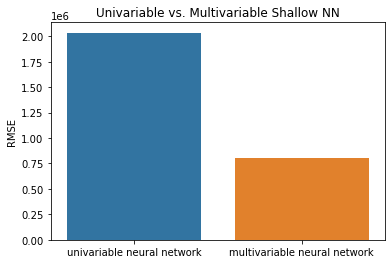

In [13]:
ax = sns.barplot(x=["univariable neural network", "multivariable neural network"], y=[2035016.625,804724.75])
ax.set_ylabel("RMSE")
ax.set_title("Univariable vs. Multivariable Shallow NN")
#ax1.set_ylabel('volts')
plt.savefig('test_rmse_usnn_vs_msnn.png')

We can see there is a clear improvement using the multivariable model over the univariable model. A 60.46% improvement over the univariable model. 2.5 times decrease.